# Running Simulations of Dark Matter Subhalos Through Star Streams

This notebook contains three methods to simulate the interactions between a star stream and a dark matter subhalo. Please look at the [galpy documentation](https://docs.galpy.org/en/latest/index.html) for more details. Requires galpy v1.72 or above

In [2]:
import galpy
## Import milky way potential and other potential profiles
from galpy.potential import MWPotential2014 as mw, MovingObjectPotential, HernquistPotential
from galpy.orbit import Orbit
from astropy import units
import numpy as np
from galpy import potential
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from galpy.util import conversion
from galpy.df import streamspraydf

# Method #1
## Creating a control star stream
First we create a star stream without the influence of any dark matter subhalo. To do this, we import the Milky Way potential given in the galpy package and then create an orbit for the progenitor of the star stream to follow around the galaxy. 

In [3]:
## Choose a radial and velocity scaling factor (the default setting is ro=8, vo=220)
ro = 12 #kpc
vo = 330 #km/s

##set mass of progenitor
mass = 1e5 ## solar masses

## Calculate conversion factors automatically from Galpy
to=conversion.time_in_Gyr(ro=ro,vo=vo)
mo=conversion.mass_in_msol(ro=ro,vo=vo)

## Set potential as imported Milky Way potential 
pot = mw

## Choose a number of stars per stream
nstar = 1000

## Set up a range of time for integrations to take place over

t1 = 1
t2 = 2.5
t = np.linspace(0, t2/to, 2500)
t_rev = np.linspace(t2/to, 0, 2500)

In [4]:
## Set up the orbit for the progenitor
## Conditions used here are the FINAL conditions
o_prog= Orbit([1.,0,1, 0, 0, 3.1], ro=ro, vo=vo)

## Sets return values to galpy unit which works better for streamspray
o_prog.turn_physical_off()

## Create star stream (INTEGRATES BACKWARDS, DISRUPTION IS ASSUMED TO HAVE HAPPENED tdisrupt TIME AGO)
## Leading stream
spdf= streamspraydf(mass/mo,
                   progenitor=o_prog,
                   pot=pot,
                   tdisrupt=t2/to)
## Trailing stream
spdft= streamspraydf(mass/mo,
                   progenitor=o_prog,
                   pot=pot,
                   tdisrupt=t2/to,
                   leading=False)

## Set random seed to ensure same control stream is generated each time
np.random.seed(seed = 1)

## Sampling process will take a minute to run 
RvR,dt= spdf.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
RvRt,dtt= spdft.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
vxvva=np.column_stack([np.append(RvR[0],RvRt[0]),
                       np.append(RvR[1],RvRt[1]),
                       np.append(RvR[2],RvRt[2]),
                       np.append(RvR[3],RvRt[3]),
                       np.append(RvR[4],RvRt[4]),
                       np.append(RvR[5],RvRt[5])])

## Keeps track of how long the star has been ejected from the progenitor
tall=np.append(dt, dtt)

## Create new orbit with all the stars within the stream
oall=Orbit(vxvva, ro=ro, vo=vo)

/home/student12/.local/lib/python3.10/site-packages/galpy/util/__init__.py:132: RuntimeWarning: invalid value encountered in divide
  rotaxis/= numpy.tile(numpy.sqrt(numpy.sum(rotaxis**2.,axis=1)),(3,1)).T



In [5]:
## Integrate all the stars in the stream backward in time to allow for plotting and animating
## Integration will take 5-10 seconds
oall.integrate(t_rev, pot)
o_prog.integrate(t_rev, pot)

## New Stream

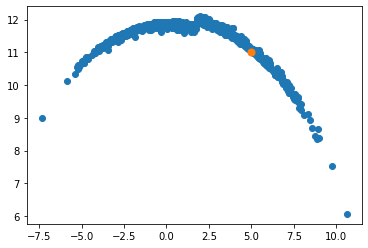

In [6]:
## Pick a time when you want the DM subhalo to intersect with the star stream
t_disrupt = 1.1/to ## DON'T FORGET THE CONVERSION FACTOR 

## Trial coordinates as to where the subhalo should be at intersection time to ensure it crosses the star stream
x_try = 5
y_try = 11

## Determine which stars have been ejected from the progenitor at this time and plot to see 
#if intersection takes place
x = []
y = []
for i in range(len(tall)):
    if (t2/to-tall[i]) <=t_disrupt:
        x.append(oall.x(t_disrupt)[i])
        y.append(oall.y(t_disrupt)[i])
plt.scatter(x, y)
plt.scatter(x_try, y_try, 50)
plt.show()

In [7]:
## Finds the closest point along the stream to the point I chose above
def find_closest(x, y, tall, o, time):
    """
    x - x coordinate of the point chosen
    y - y coordinate of the point chose
    tall - ejection time of all the stars in the stream
    o - orbit of the stream
    time - time of intersection
    returns array containing minimum distance, radius of the point on the stream
    phi of the point along the stream and index in orbit of the closest star
    """
    ox = []
    oy = []
    indexes = []
    for i in range(len(o.x())):
        if (t2/to-tall[i]) <= time:
            ox.append(o.x(time)[i])
            oy.append(o.y(time)[i])
            indexes.append(i)
    xs = np.ones(len(ox))*x
    ys = np.ones(len(ox))*y
    d= np.sqrt((ox-xs)**2 + (oy-ys)**2)
    if (len(d) >0):
        min_d = min(d) 
        min_index = indexes[np.where(d==min_d)[0][0]]
        min_r = o.R(time)[min_index]
        min_phi = o.phi(time)[min_index]
        return [min_d, min_r, min_phi, min_index]

In [8]:
d, r, phi, i = find_closest(x_try, y_try,  tall, oall, t_disrupt)

## Define orbit of the DM subhalo, can choose whatever speed you want, note these are the conditions are t_disrupt
o_dm = Orbit([r, 0.8, 0.4,0.000125,0,phi], ro=ro, vo=vo)

## Integrate the dark matter subhalo from t_disrupt to its initial position
td_rev = np.linspace(t_disrupt, 0, int(t_disrupt*to*1000))
o_dm.integrate(td_rev, pot)

## Then integrate subhalo orbit from initial position to final position so we have the whole trajectory
o_dm = Orbit([o_dm.R(0)/ro, o_dm.vR(0)/vo, o_dm.vT(0)/vo,o_dm.z(0)/ro,o_dm.vz(0)/vo,o_dm.phi(0)], ro=ro, vo=vo)
o_dm.turn_physical_off()
o_dm.integrate(t, pot)

## Create a moving object potential for the subhalo and add total potential
## (Here I am using Hernquist profile, but you can use other potentials from the galpy library too)
mass_dm = 1e8 ## solar masses
rscale_dm = 0.01
hp = HernquistPotential(mass_dm/mo, rscale_dm/ro)
pot_dm = MovingObjectPotential(o_dm, hp)
total_pot = [pot]
total_pot += [pot_dm]

In [9]:
## Create stream with influence of the dark matter subhalo
spdf_dm= streamspraydf(mass/mo,
                   progenitor=o_prog,
                   pot=total_pot,
                       rtpot = pot,
                   tdisrupt=t2/to)

spdft_dm= streamspraydf(mass/mo,
                   progenitor=o_prog,
                   pot=total_pot,
                       rtpot = pot,
                   tdisrupt=t2/to,
                   leading=False)

np.random.seed(seed = 1)

RvR,dt= spdf_dm.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
RvRt,dtt= spdft_dm.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
vxvva=np.column_stack([np.append(RvR[0],RvRt[0]),
                       np.append(RvR[1],RvRt[1]),
                       np.append(RvR[2],RvRt[2]),
                       np.append(RvR[3],RvRt[3]),
                       np.append(RvR[4],RvRt[4]),
                       np.append(RvR[5],RvRt[5])])

tall_dm=np.append(dt, dtt)

oall_dm=Orbit(vxvva, ro=ro, vo=vo)
oall_dm.turn_physical_off()

In [10]:
oall_dm.integrate(t_rev, total_pot)

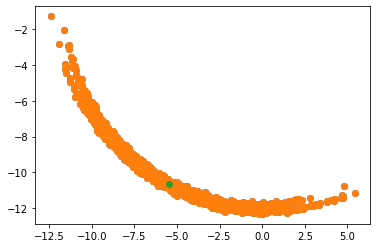

In [11]:
## Plotting End positions, change times as desired
plt.scatter(oall.x(1.2/to), oall.y(1.2/to))
plt.scatter(oall_dm.x(1.2/to)*ro, oall_dm.y(1.2/to)*ro)
plt.scatter(o_prog.x(1.2/to)*ro, o_prog.y(1.2/to)*ro)
#plt.plot(o_dm.x(t), o_dm.y(t))
plt.show()

# Method #2
For this method, the streamspray is turned off after the first Gyr, which simplifies things. In the second part of the stream, the subhalo is turned on long enough to interact with the stream once before it is turned off again. 

/home/student12/.local/lib/python3.10/site-packages/galpy/util/__init__.py:132: RuntimeWarning: invalid value encountered in divide
  rotaxis/= numpy.tile(numpy.sqrt(numpy.sum(rotaxis**2.,axis=1)),(3,1)).T



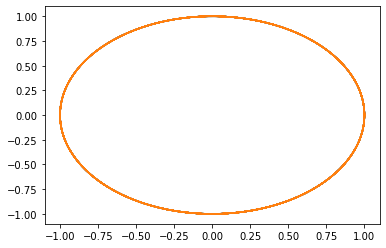

In [11]:
## This is now the condition after 1 Gyr
o_prog3= Orbit([1.,0,1, 0, 0, 3.1], ro=ro, vo=vo)
o_prog3.turn_physical_off()

t_s1 = np.linspace(t1/to, t2/to, 1500)
t_srev = np.linspace(t2/to, t1/to, 1000)
## Integrate the orbit to its final position
o_prog3.integrate(t_s1, pot)
plt.plot(o_prog3.x(t_s1), o_prog3.y(t_s1))
 
## New progenitor orbit initiated from final position
o_prog3_2 = Orbit([o_prog3.R(t2/to), o_prog3.vR(t2/to), 
                o_prog3.vT(t2/to), o_prog3.z(t2/to), 
                o_prog3.vz(t2/to), o_prog3.phi(t2/to)], ro=ro, vo=vo)
o_prog3_2.turn_physical_off()
o_prog3_2.integrate(t_rev, pot)
plt.plot(o_prog3_2.x(t_s1), o_prog3_2.y(t_s1))

spdf3= streamspraydf(mass/mo,
                   progenitor=o_prog3,
                   pot=pot,
                   tdisrupt=t1/to)

spdft3= streamspraydf(mass/mo,
                   progenitor=o_prog3,
                   pot=pot,
                   tdisrupt=t1/to,
                   leading=False)

np.random.seed(seed = 1)

RvR3,dt3= spdf3.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
RvRt3,dtt3= spdft3.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
vxvva3=np.column_stack([np.append(RvR3[0],RvRt3[0]),
                       np.append(RvR3[1],RvRt3[1]),
                       np.append(RvR3[2],RvRt3[2]),
                       np.append(RvR3[3],RvRt3[3]),
                       np.append(RvR3[4],RvRt3[4]),
                       np.append(RvR3[5],RvRt3[5])])

tall3=np.append(dt, dtt)

oall3=Orbit(vxvva3, ro=ro, vo=vo)

oall3_2 = Orbit(vxvva3, ro=ro, vo=vo)


In [12]:
oall3.integrate(t_s1, pot)

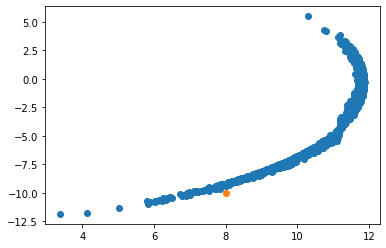

In [13]:
## Check the DM subhalo trajectory coincides with the star stream
plt.scatter(oall3.x(1.1/to), oall3.y(1.1/to))
y_try = -10
x_try = 8
plt.scatter(x_try, y_try)
phi = np.arctan2(y_try, x_try)

In [14]:
mass_dm=1e1 #solar masses
rscale_dm=0.01 #kpc
hp = HernquistPotential(mass_dm/mo, rscale_dm/ro)

In [15]:
## Set conditions of dark matter at time of interaction
o_dm = Orbit([1, 1.1, 0.1, 0.000125, 0, phi], ro=ro, vo=vo)
o_dm.turn_physical_off()
dmt = np.linspace(t1/to, (t1+0.2)/to, 200)
dmt_rev = np.linspace((t1+0.1)/to, t1/to,100)
dmt_rev2 = np.linspace((t1+0.2)/to, t1/to,200)
## Integrate back to 1 Gyr
o_dm.integrate(dmt_rev, pot)
o_dm2 = Orbit([o_dm.R(t1/to), o_dm.vR(t1/to), 
                o_dm.vT(t1/to), o_dm.z(t1/to), 
                o_dm.vz(t1/to), o_dm.phi(t1/to)], ro=ro, vo=vo)
## Integrate forward to 1.2 Gyr
o_dm2.integrate(dmt, pot)
o_dm2.turn_physical_off()
o_dm3 = Orbit([o_dm2.R(1.2/to), o_dm2.vR(1.2/to), 
                o_dm2.vT(1.2/to), o_dm2.z(1.2/to), 
                o_dm2.vz(1.2/to), o_dm2.phi(1.2/to)], ro=ro, vo=vo)
o_dm3.turn_physical_off()

## Make moving potential
pot_dm = MovingObjectPotential(o_dm2, hp)
total_pot += [pot_dm]

## Integrate star stream to 1.2 Gyr with dark matter potential
oall3.integrate(dmt, total_pot)
oall3_3 = Orbit(np.column_stack([oall3.R((t1+0.2)/to)/ro, oall3.vR((t1+0.2)/to)/vo, 
                oall3.vT((t1+0.2)/to)/vo, oall3.z((t1+0.2)/to)/ro, 
                oall3.vz((t1+0.2)/to)/vo, oall3.phi((t1+0.2)/to)]), ro=ro, vo=vo)
postt = np.linspace((t1+0.2)/to, t2/to, 1300)
postt_rev = np.linspace(t2/to, (t1+0.2)/to, 1300)
oall3_3.integrate(postt, pot)
oall3_final = Orbit(np.column_stack([oall3_3.R(t2/to)/ro, oall3_3.vR(t2/to)/vo, 
                oall3_3.vT(t2/to)/vo, oall3_3.z(t2/to)/ro, 
                oall3_3.vz(t2/to)/vo, oall3_3.phi(t2/to)]), ro=ro, vo=vo)

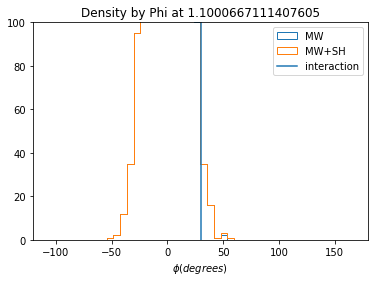

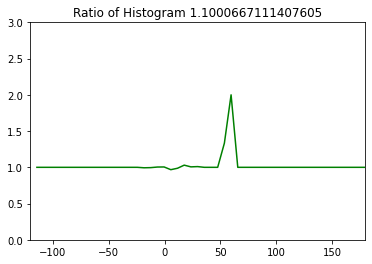

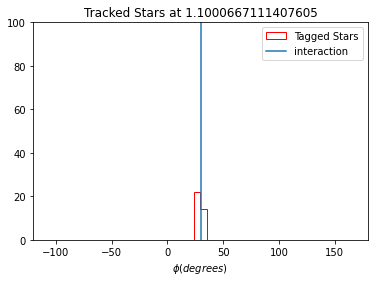

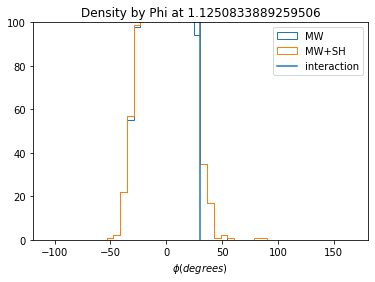

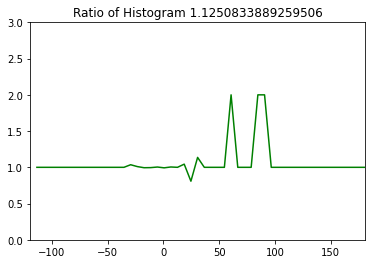

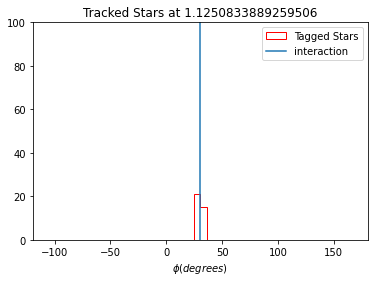

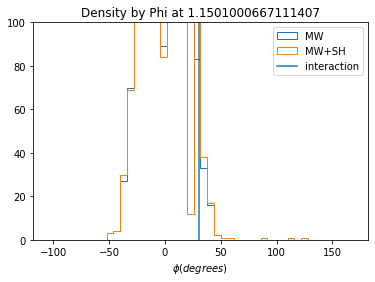

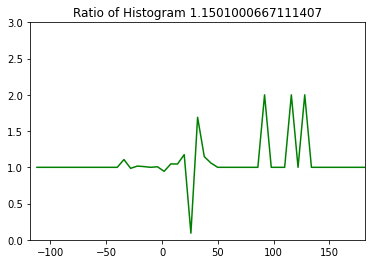

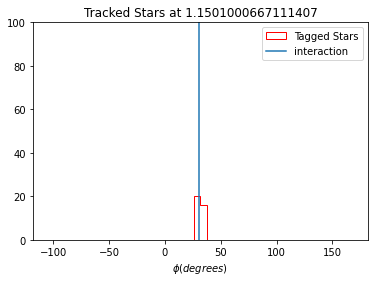

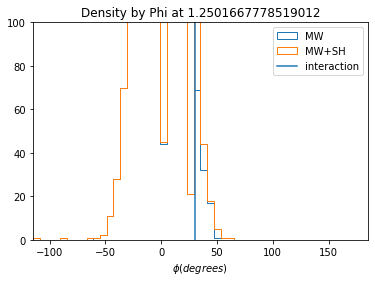

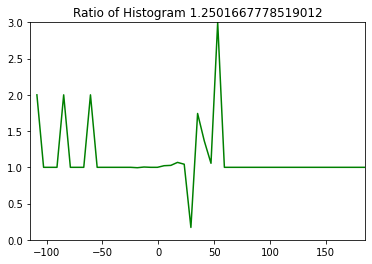

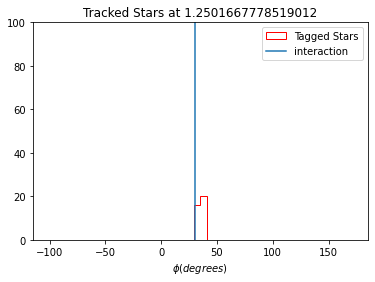

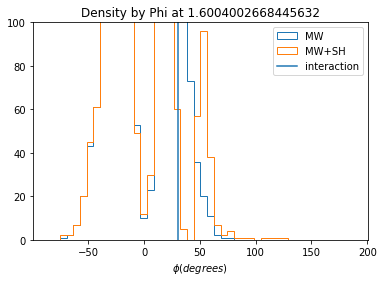

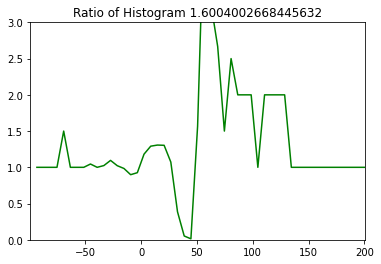

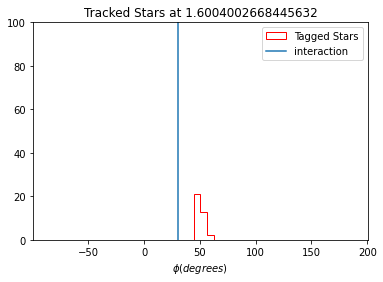

In [16]:
iterate0= 100
oall3.integrate(t_s1, pot)
oall3_2.integrate(dmt, total_pot)
oall3_final.integrate(postt_rev, pot)
o_prog3_2.integrate(t_rev, pot)
o_dm2.integrate(dmt, pot)

## Function to phase shift phi to center around progenitor, ranging from -180 to 180
def phase_shift(phis):
    new = []
    for index,i in enumerate(phis):
            if i > 180:
                new.append(i-360)
            elif i < -180:
                new.append(i+360)
            else:
                new.append(i)
    return new

## Tag the nearby stars at point of interaction
def tag(phis, dm):
    tagged = []
    for i in range(len(phis)):
        if abs(dm-phis[i]) < 2:
            tagged.append(i)
    return tagged

tags = []
dm = []

## Calculate angle between trajectory of subhalo and trajectory of star stream
angle = 90+ np.arctan(o_dm2.vT(t_s1[iterate0])/o_dm2.vR(t_s1[iterate0]))/(2*np.pi) * 360


## Plot histogram of distribution of stars
def plot_phi(iterate, tf):
    global tags, dm, all_ratios, all_tags
    if t_s1[iterate] < dmt[-1]:
        phimw=np.arctan2(oall3.y(t_s1[iterate]),oall3.x(t_s1[iterate]))
        phish=np.arctan2(oall3_2.y(t_s1[iterate]),oall3_2.x(t_s1[iterate]))
        prog = np.arctan2(o_prog3_2.y(t_s1[iterate]), o_prog3_2.x(t_s1[iterate]))
        phim1 = (prog - phimw)/(2*np.pi) * 360
        phis1 = (prog - phish)/(2*np.pi) * 360
        phim = phase_shift(phim1)
        phis = phase_shift(phis1)
        if tf:
            dm = np.arctan2(o_dm2.y(t_s1[iterate]), o_dm2.x(t_s1[iterate]))
            dm = phase_shift([(prog-dm)/(2*np.pi) * 360]) #, [2.5/to])
            tags = tag(phis, dm[0])
    
    else:
        phimw=np.arctan2(oall3.y(t_s1[iterate]),oall3.x(t_s1[iterate]))
        phish=np.arctan2(oall3_3.y(t_s1[iterate]),oall3_3.x(t_s1[iterate]))
        prog = np.arctan2(o_prog3_2.y(t_s1[iterate]), o_prog3_2.x(t_s1[iterate]))
        phim1 = (prog - phimw)/(2*np.pi) * 360
        phis1 = (prog - phish)/(2*np.pi) * 360
        phim = phase_shift(phim1)
        phis = phase_shift(phis1)
    
    distance = 0
    tagged_stars = []
    for j in tags:
        tagged_stars.append(phis[j])
        distance += (dm[0]-phis[j])**2
        
    ## Mean degrees of tagged stars to use for zooming in
    mean_phi = np.mean(tagged_stars)
    
    ## RMS of distances
    distance = np.sqrt(distance/len(tags))
    
    nmw,binsmw,patchesmw=plt.hist(phim, 50, range=(mean_phi-150, mean_phi+150), label='MW', histtype='step')
    nsh,binssh,patchessh=plt.hist(phis, bins=binsmw, range=(mean_phi-150, mean_phi+150), label='MW+SH', histtype = 'step')
    plt.axvline(dm[0], label="interaction")
    plt.ylim([0,100])
    plt.xlim([mean_phi-150, mean_phi+150])
    plt.xlabel(r'$\phi(degrees)$')
    plt.title("Density by Phi at "+ str(t_s1[iterate]*to))
    plt.legend()
    plt.show()
    
    ## Ratio of 2 histograms
    ratios = (nsh+1)/(nmw+1)

    plt.plot(binsmw[1:], ratios, c="green")
    plt.ylim([0,3])
    plt.xlim([mean_phi-150, mean_phi+150])
    plt.title("Ratio of Histogram "+str(t_s1[iterate]*to))
    plt.show()

    plt.hist(tagged_stars,bins=binsmw, range=(mean_phi-150, mean_phi+150),
             label='Tagged Stars', histtype='step', color = 'red')
    plt.axvline(dm[0], label="interaction")
    plt.ylim([0,100])
    plt.xlim([mean_phi-150, mean_phi+150])

    plt.xlabel(r'$\phi(degrees)$')
    plt.title("Tracked Stars at "+ str(t_s1[iterate]*to))
    plt.legend()
    plt.show()

## Plot for 25, 50, 150 and 500 million years into the future
    
time_range = [iterate0, iterate0+25, iterate0+50, iterate0+150, iterate0+500]  
plot_phi(time_range[0], True)
plot_phi(time_range[1], False)
plot_phi(time_range[2], False)
plot_phi(time_range[3], False)
plot_phi(time_range[4], False)

# Multiple Subhalos
This code imports subhalo data from the ETHOS simulations and takes the top ten most massive subhalos and runs a star stream through them. The initial conditions of the star stream can be changed to have better interactions.

In [17]:
import os
import h5py
mass = 1e5
nstar = 1000
tdisrupt1 = 2
tdisrupt2 = 5
rscale_dm = 0.01
ro = 100
vo = 2750
pot = mw
to=conversion.time_in_Gyr(ro=ro,vo=vo)
mo=conversion.mass_in_msol(ro=ro,vo=vo)
t = np.linspace(0, tdisrupt2/to, 2500)
t_rev = np.linspace(tdisrupt2/to, 0, 2500)
t1 = np.linspace(tdisrupt1/to, tdisrupt2/to, 1500)
t2 = np.linspace(tdisrupt1/to, (tdisrupt1+0.1)/to, 100)
t3 = np.linspace((tdisrupt1+0.1)/to, tdisrupt2/to, 1400)
t_rev1 = np.linspace(tdisrupt2/to, tdisrupt1/to, 1500)
total_pot = [pot]

In [18]:
o_prog4= Orbit([0.5,0,0.5, 0.1, 0, 2.1], ro=ro, vo=vo)
o_prog4.turn_physical_off()
o_prog4.integrate(t1, pot)
o_prog4_2 = Orbit([o_prog4.R(tdisrupt2/to), o_prog4.vR(tdisrupt2/to), 
                o_prog4.vT(tdisrupt2/to), o_prog4.z(tdisrupt2/to), 
                o_prog4.vz(tdisrupt2/to), o_prog4.phi(tdisrupt2/to)], ro=ro, vo=vo)
o_prog4_2.turn_physical_off()
o_prog4_2.integrate(t_rev, pot)

In [19]:
## Create a star stream for 
spdf4= streamspraydf(mass/mo,
                   progenitor=o_prog4,
                   pot=pot,
                   tdisrupt=tdisrupt1/to)
#Distribution function for the trailing tail
spdft4= streamspraydf(mass/mo,
                   progenitor=o_prog4,
                   pot=pot,
                   tdisrupt=tdisrupt1/to,
                   leading=False)

np.random.seed(seed = 1)
RvR4,dt4= spdf4.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
RvRt4,dtt4= spdft4.sample(n=nstar,returndt=True,integrate=True, return_orbit = False)
vxvva4=np.column_stack([np.append(RvR4[0],RvRt4[0]),
                       np.append(RvR4[1],RvRt4[1]),
                       np.append(RvR4[2],RvRt4[2]),
                       np.append(RvR4[3],RvRt4[3]),
                       np.append(RvR4[4],RvRt4[4]),
                       np.append(RvR4[5],RvRt4[5])])

oall4=Orbit(vxvva4, ro=ro, vo=vo)
oall_4 = Orbit(vxvva4, ro=ro, vo=vo)
tall4=np.append(dt4, dtt4) #dt

In [20]:
## Customize for where ETHOS files are stored
i = 1
dmtype = 'ETHOS-'+str(i)
path = "ETHOS/"+dmtype+"/ZOOMINS/power_only/groups_127"
path2 = "ETHOS/CDM/ZOOMINS/groups_127"

ext = ('.hdf5')
masses = []
positions = []
vel = []
radii = []

## Access h5py files and import subhalo data
f1 = h5py.File(path+'/'+'fof_subhalo_tab_127.0.hdf5', 'r')
parent_pos = f1['Group']['GroupPos'][:]
for filename in os.listdir(path):
    if filename.endswith(ext):
        f = h5py.File(path+'/'+filename, 'r')
        h = f['Header'].attrs['HubbleParam']
        if len(f['Subhalo'])> 0:
            pos = list(f['Subhalo']['SubhaloPos'][:]/h)
            pos1 = (pos-parent_pos/h)
            ## Set x, y and z conditions
            pos_cond = np.logical_and(pos1 < 300, pos1 > -300).all(axis=1)
            pos2 = pos1[pos_cond]
            xs = np.array(pos2)[:,0]
            ys = np.array(pos2)[:,1]
            zs = np.array(pos2)[:,2]
            rad = np.sqrt(xs**2 + ys**2 +zs**2)
            ## Set radius conditions
            #rad_cond = (rad<300)
            radii.extend(rad)
            positions.extend(pos2)
            masses.extend(list(f['Subhalo']['SubhaloMass'][:][pos_cond]*1e10/h))           
            vel.extend(list(f['Subhalo']['SubhaloVel'][:][pos_cond]/h))
        f.close()

## Find index of top ten most massive subhalos
top_ten_ind = sorted(range(len(masses)), key=lambda i: masses[i], reverse=True)[1:11]
orbits = []
xs = np.array(positions)[:,0]
ys = np.array(positions)[:,1]
zs = np.array(positions)[:,2]

## Compile information from the top ten subhalos
for i in top_ten_ind:
    x = xs[i]
    x_km = x * 3.086e16
    y = ys[i]
    y_km = y * 3.086e16
    z= zs[i]
    radius =radii[i]
    r_km = radius * 3.086e16
    phi= (np.arctan2(y, x))
    phi_dot = (x_km*vel[i][1]+y_km*vel[i][0])/(x_km**2+y_km**2)
    rho_dot = (x_km*vel[i][0]+ y_km*vel[i][1])/np.sqrt(x_km**2+y_km**2)
    m = masses[i]
    orbits.append([radius/ro, rho_dot/vo, r_km*phi_dot/vo, z/ro, vel[i][2]/vo, phi, m])

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'ETHOS/ETHOS-1/ZOOMINS/power_only/groups_127/fof_subhalo_tab_127.0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
## Finds the closest point along the stream to point (x, y, z) 
def find_closest(x, y, z, ox, oy, oz):
    xs = np.ones(len(ox))*x
    ys = np.ones(len(ox))*y
    zs = np.ones(len(oz))*z
    d= np.sqrt((ox-xs)**2 + (oy-ys)**2+(oz-zs)**2)
    if (len(d) >0):
        min_d = min(d) 
        return min_d

## Integrate normal stream
oall4.integrate(t1, pot)

## Create orbits for subhalos and add to total potential
dm_orbits = []
for orbit in orbits:
    o_dm = Orbit(orbit[:-1], ro=ro, vo=vo)
    o_dm.turn_physical_off()
    o_dm.integrate(t_rev1, pot)
    dm_orbits.append(o_dm)
    hp = HernquistPotential(orbit[-1]/mo, rscale_dm/ro)
    pot_dm = MovingObjectPotential(o_dm, hp)
    total_pot +=[pot_dm]
    distances=[]
    for i in t1:
       ## Track distances of each subhalo to the star stream
       distances.append(find_closest(o_dm.x(i), o_dm.y(i), o_dm.z(i), oall4.x(i), oall4.y(i), oall4.z(i)))

## Integrate new stream
oall_4.integrate(t1, total_pot)

In [ ]:
plt.scatter(oall4.x(t1[1400]), oall4.y(t1[1400]))
plt.show()
plt.scatter(oall_4.x(t1[1400]), oall_4.y(t1[1400]))
plt.show()